# NPLM Analysis

## Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from matplotlib.ticker import ScalarFormatter

from NPLM.PLOTutils import *
from NPLM.ANALYSISutils import *

%load_ext autoreload
%autoreload 1
%aimport modules.plot_utils
%aimport modules.analysis_utils
%aimport modules.DataReader



import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

## Functions

In [2]:
def read_data(file_name, n_data):
    '''legge la distribuzione da un file'''
    return modules.DataReader.DataReader(filename=file_name).build_sample(ndata=n_data)

def read_data_cut(file_name, n_data, theta1 = None, theta2 = None):
    """reads data file and perform cuts on theta"""
    Reader = modules.DataReader.DataReader(filename=file_name)
    df_cut = Reader.cut_theta(ndata=n_data, theta1=theta1, theta2=theta2)
    return df_cut

## Constants

In [22]:
N_REF           = 200000
N_BKG           = 5000
N_SIG           = 0
N_DATA          = N_BKG + N_SIG
EPOCHS          = 50000
ARCHITECTURE    = [2, 4, 4, 4, 1]
WEIGHT_CLIPPING = 5

KEY      = "loss"
PATIENCE = 1000

DATA_FOLDER    = "../data/"

REFERENCE_RUN  = "0054"
REFERENCE_SUFFIX = ""

FEATURES       = ["drift_time", "theta"]

REF_IN_FOLDER   = f"./{REFERENCE_RUN}_{REFERENCE_SUFFIX}/2D/Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
REF_IN_FOLDER  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
REF_IN_FOLDER  += f"_wclip{WEIGHT_CLIPPING}"

REF_OUT_FOLDER  = f"./out_ref/{REFERENCE_RUN}_{REFERENCE_SUFFIX}/"
REF_OUT_NAME    = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
REF_OUT_NAME   += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
REF_OUT_NAME   += f"_wclip{WEIGHT_CLIPPING}"

if not os.path.exists(REF_OUT_FOLDER):
        os.makedirs(REF_OUT_FOLDER)
        
print(REF_IN_FOLDER)

./0054_/2D/Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5


## NPLM Analysis

### Reference

In [23]:
values, files_id_tau, seeds_tau = collect_txt(
    DIR_IN       = REF_IN_FOLDER, 
    suffix       = 'TAU',
    files_prefix = [],
    verbose      = False
)

save_txt_to_h5(
    tvalues   = values,
    files_id  = files_id_tau,
    seeds     = seeds_tau,
    suffix    = "t",
    DIR_OUT   = REF_OUT_FOLDER,
    FILE_NAME = REF_OUT_NAME
)

Saved to file: ./out_ref/0054_//Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5_t.h5


In [24]:
key_history = collect_history(
    files_id = files_id_tau,
    DIR_IN   = REF_IN_FOLDER,
    suffix   = '_TAU',
    key      = KEY,
    verbose  = False
)

save_history_to_h5(
    tvalues_check = key_history, 
    seeds         = seeds_tau,
    suffix        = 'history', 
    patience      = PATIENCE, 
    DIR_OUT       = REF_OUT_FOLDER, 
    FILE_NAME     = REF_OUT_NAME, 
)

Saved to file: ./out_ref/0054_//Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5_history.h5


In [25]:
tau, tau_seeds = Read_final_from_h5(
    DIR_IN    = REF_OUT_FOLDER,
    FILE_NAME = REF_OUT_NAME,
    suffix    = '_t'
)
tau_history = Read_history_from_h5(
    DIR_IN    = REF_OUT_FOLDER,
    FILE_NAME = REF_OUT_NAME,
    suffix    = '_history'
)

ttau = np.expand_dims(tau, axis=1)
tau_history = np.delete(tau_history, 0, axis=1)
tau_history = np.hstack((tau_history, ttau))

Reading ./out_ref/0054_/Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5_t.h5
Output shape:
(40,)
Returning test statistics and seeds
Reading ./out_ref/0054_/Nref200000_Ndata5000_epochsTau50000_arc2_4_4_4_1_wclip5_history.h5
Output shape:
(40, 50)
Returning history


In [26]:
dof = compute_df(ARCHITECTURE[0], ARCHITECTURE[1:-1], ARCHITECTURE[-1])
modules.analysis_utils.t_median(tau, dof)


Median t distribution: 56.04385
Median chi2 (ndf=57): 56.33474

Median p-value: 0.5000        Median significance: -0.0000        from t list
Median p-value: 0.5110        Median significance: -0.0275        from chi2 distribution


In [29]:
np.random.seed(seed=233423)
tau = scipy.stats.chi2.rvs(df=57, size=500)

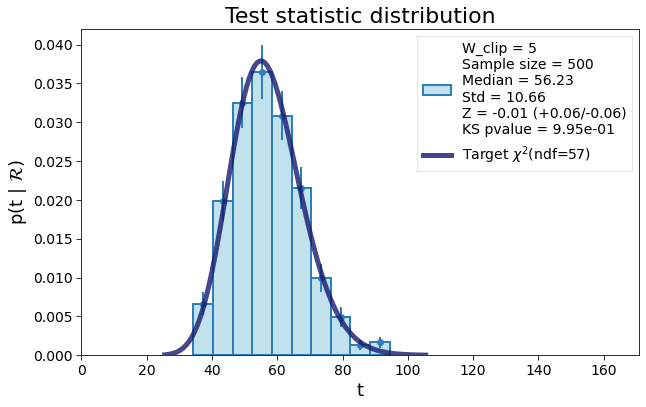

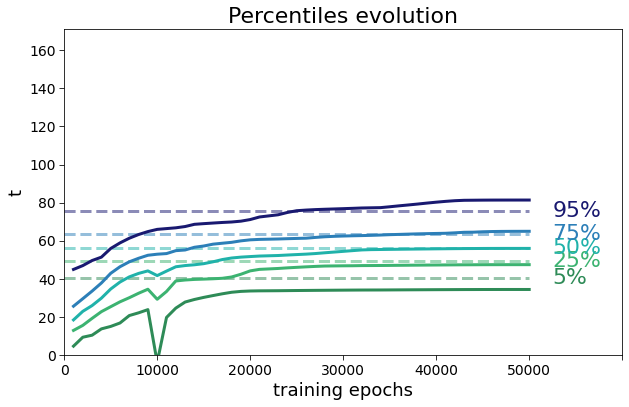

In [31]:
SAVE = False

save_path = f"./plots/{REFERENCE_RUN}_{REFERENCE_SUFFIX}/"
if not os.path.exists(save_path):
        os.makedirs(save_path)

file_name   = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
file_name  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
file_name  += f"_wclip{WEIGHT_CLIPPING}"

modules.analysis_utils.plot_1distribution(
    t=tau, 
    df=dof, 
    xmin=None, 
    xmax=None, 
    nbins=10, 
    wclip=WEIGHT_CLIPPING, 
    save=SAVE, 
    save_path=save_path, 
    file_name=file_name
)
modules.analysis_utils.plot_percentiles(
    tvalues_check=tau_history, 
    df=dof, 
    patience=1000, 
    ymin=0, 
    ymax=None, 
    wclip=WEIGHT_CLIPPING, 
    smooth=True, 
    save=SAVE,
    save_path=save_path, 
    file_name=file_name
)